In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [67]:
deliveries = pd.read_csv("deliveries.csv")
matches = pd.read_csv("matches.csv")
matches['season'] = matches['season'].apply(lambda x: int(str(x).split('/')[0]))

deliveries = deliveries.merge(matches[['id', 'season']].rename(columns={'id': 'match_id'}), on='match_id', how='left')

In [68]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,season
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN,2007
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN,2007
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN,2007
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN,2007
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN,2007


In [69]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          260920 non-null  int64 
 1   inning            260920 non-null  int64 
 2   batting_team      260920 non-null  object
 3   bowling_team      260920 non-null  object
 4   over              260920 non-null  int64 
 5   ball              260920 non-null  int64 
 6   batter            260920 non-null  object
 7   bowler            260920 non-null  object
 8   non_striker       260920 non-null  object
 9   batsman_runs      260920 non-null  int64 
 10  extra_runs        260920 non-null  int64 
 11  total_runs        260920 non-null  int64 
 12  extras_type       14125 non-null   object
 13  is_wicket         260920 non-null  int64 
 14  player_dismissed  12950 non-null   object
 15  dismissal_kind    12950 non-null   object
 16  fielder           9354 non-null    obj

In [70]:
deliveries['phase'] = deliveries['over'].apply(lambda x: 'powerplay' if x <= 6 else 'middle' if x <= 15 else 'death')
deliveries['is_boundary'] = deliveries['batsman_runs'].isin([4, 6]).astype(int)
deliveries['is_dot'] = (deliveries['total_runs'] == 0).astype(int)
deliveries['is_wicket'] = deliveries['player_dismissed'].notnull().astype(int)

batter_game_phase = deliveries.groupby(['batter', 'match_id', 'phase']).agg(
    runs=('batsman_runs', 'sum'),
    balls=('ball', 'count'),
    boundaries=('is_boundary', 'sum'),
    dot_balls=('is_dot', 'sum'),
    dismissals=('is_wicket', 'sum')
).reset_index()

batter_game = batter_game_phase.pivot(index=['batter', 'match_id'], columns='phase')
batter_game.columns = ['_'.join(col).strip() for col in batter_game.columns.values]
batter_game = batter_game.fillna(0).reset_index()

batter_agg = batter_game.groupby('batter').agg({
    'runs_powerplay': 'mean', 'balls_powerplay': 'mean', 'boundaries_powerplay': 'mean', 'dot_balls_powerplay': 'mean',
    'runs_middle': 'mean', 'balls_middle': 'mean', 'boundaries_middle': 'mean', 'dot_balls_middle': 'mean',
    'runs_death': 'mean', 'balls_death': 'mean', 'boundaries_death': 'mean', 'dot_balls_death': 'mean',
    'match_id': 'count'
}).rename(columns={'match_id': 'games_played'}).reset_index()

for phase in ['powerplay', 'middle', 'death']:
    batter_agg[f'sr_{phase}'] = (batter_agg[f'runs_{phase}'] / batter_agg[f'balls_{phase}'].replace(0, np.nan)) * 100
    batter_agg[f'boundary_pct_{phase}'] = (batter_agg[f'boundaries_{phase}'] / batter_agg[f'balls_{phase}'].replace(0, np.nan)) * 100
    batter_agg[f'dot_pct_{phase}'] = (batter_agg[f'dot_balls_{phase}'] / batter_agg[f'balls_{phase}'].replace(0, np.nan)) * 100

batter_agg = batter_agg.merge(deliveries.groupby('batter')['season'].min().reset_index().rename(columns={'season': 'debut_year'}), on='batter')

In [71]:
def assign_role(row):
    if row['sr_powerplay'] > 120 and row['boundary_pct_powerplay'] > 20:
        return 'top_order'
    elif row['sr_death'] > 160 and row['boundary_pct_death'] > 25:
        return 'finisher'
    elif row['sr_middle'] > 120 and row['boundary_pct_middle'] > 15:
        return 'middle_order'
    else:
        return 'others'

batter_agg['role'] = batter_agg.apply(assign_role, axis=1)
batter_agg['elite'] = (
    (batter_agg['sr_powerplay'] > 130) |
    (batter_agg['sr_middle'] > 130) |
    (batter_agg['sr_death'] > 160)
).astype(int)

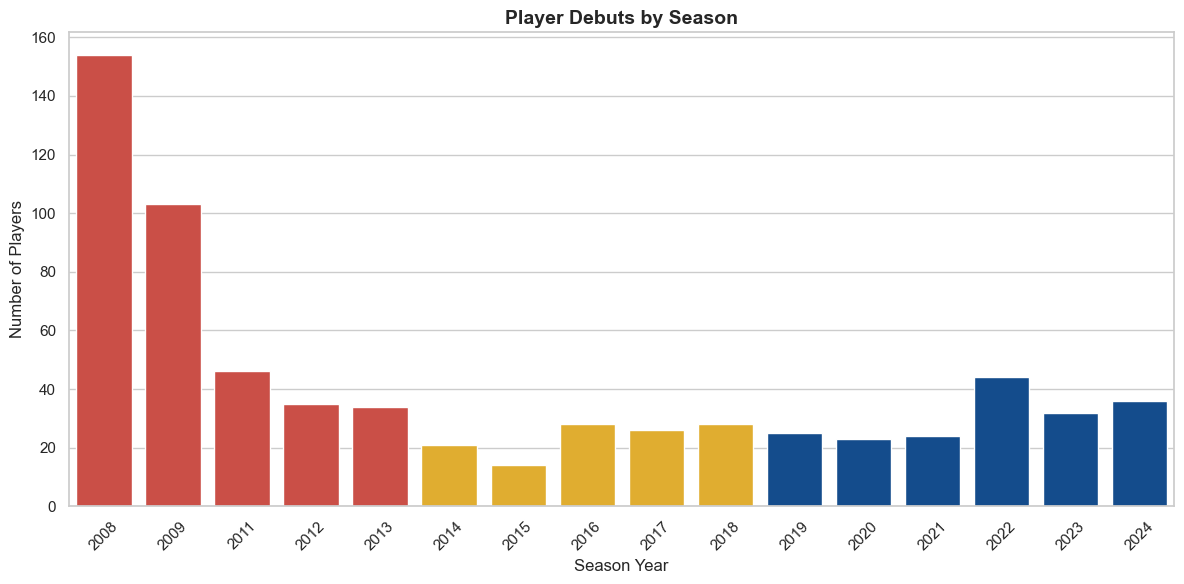

In [84]:
# Rename 2007 to 2008 in the debut_year column
batter_agg['debut_year'] = batter_agg['debut_year'].replace(2007, 2008)

# Define IPL role-based color gradient (RCB → CSK → MI)
ipl_cmap = ListedColormap(["#E03C31", "#FDB913", "#004BA0"])  # Red, Yellow, Blue

# Generate unique debut years in sorted order
unique_years = sorted(batter_agg['debut_year'].dropna().unique())

# Create a color palette matching the number of debut years
custom_palette = sns.color_palette(ipl_cmap(np.linspace(0, 1, len(unique_years))))

# Plot with updated debut year and custom IPL color palette
plt.figure(figsize=(12, 6))
sns.countplot(x='debut_year', data=batter_agg, order=unique_years, palette=custom_palette)
plt.title("Player Debuts by Season", fontsize=14, fontweight='bold')
plt.xlabel("Season Year", fontsize=12)
plt.ylabel("Number of Players", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [73]:
features = [
    'runs_powerplay', 'balls_powerplay', 'boundaries_powerplay', 'dot_balls_powerplay', 'boundary_pct_powerplay',
    'runs_middle', 'balls_middle', 'boundaries_middle', 'dot_balls_middle', 'dot_pct_middle',
    'runs_death', 'balls_death', 'boundaries_death', 'dot_balls_death', 'boundary_pct_death'
]

young_batters = batter_agg[batter_agg['debut_year'] > 2019].reset_index(drop=True)
valid_roles = young_batters[young_batters['role'].isin(['top_order', 'middle_order', 'finisher'])].copy()
valid_roles_clean = valid_roles.dropna(subset=features)

X = valid_roles_clean[features]
y = valid_roles_clean['role']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42, test_size=0.2)

rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=6)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

    finisher       1.00      0.50      0.67         2
middle_order       0.75      1.00      0.86         3
   top_order       1.00      1.00      1.00         1

    accuracy                           0.83         6
   macro avg       0.92      0.83      0.84         6
weighted avg       0.88      0.83      0.82         6



In [75]:
elite_roles = valid_roles_clean[valid_roles_clean['elite'] == 1]
elite_roles.to_csv("elite_batsmen_predictions.csv", index=False)

In [76]:
elite_roles.head()

,batter,runs_powerplay,balls_powerplay,boundaries_powerplay,dot_balls_powerplay,runs_middle,balls_middle,boundaries_middle,dot_balls_middle,runs_death,...,dot_pct_powerplay,sr_middle,boundary_pct_middle,dot_pct_middle,sr_death,boundary_pct_death,dot_pct_death,debut_year,role,elite
2,A Manohar,1.200000,1.800000,0.133333,1.066667,8.533333,7.133333,1.133333,2.266667,5.666667,...,59.259259,119.626168,15.887850,31.775701,180.851064,25.531915,25.531915,2022,finisher,1
8,AK Markram,3.809524,4.095238,0.428571,1.809524,15.761905,12.380952,1.571429,3.000000,4.119048,...,44.186047,127.307692,12.692308,24.230769,182.105263,25.263158,14.736842,2021,finisher,1
14,Abishek Porel,10.562500,7.375000,1.687500,3.062500,8.875000,6.250000,1.062500,1.750000,3.062500,...,41.525424,142.000000,17.000000,28.000000,188.461538,30.769231,15.384615,2023,top_order,1
19,Anuj Rawat,4.476190,4.761905,0.619048,2.428571,4.619048,5.095238,0.380952,1.809524,6.047619,...,51.000000,90.654206,7.476636,35.514019,184.057971,27.536232,23.188406,2021,finisher,1
28,B Sai Sudharsan,12.920000,11.640000,1.600000,4.080000,23.760000,16.920000,2.800000,3.840000,4.680000,...,35.051546,140.425532,16.548463,22.695035,208.928571,30.357143,16.071429,2022,finisher,1


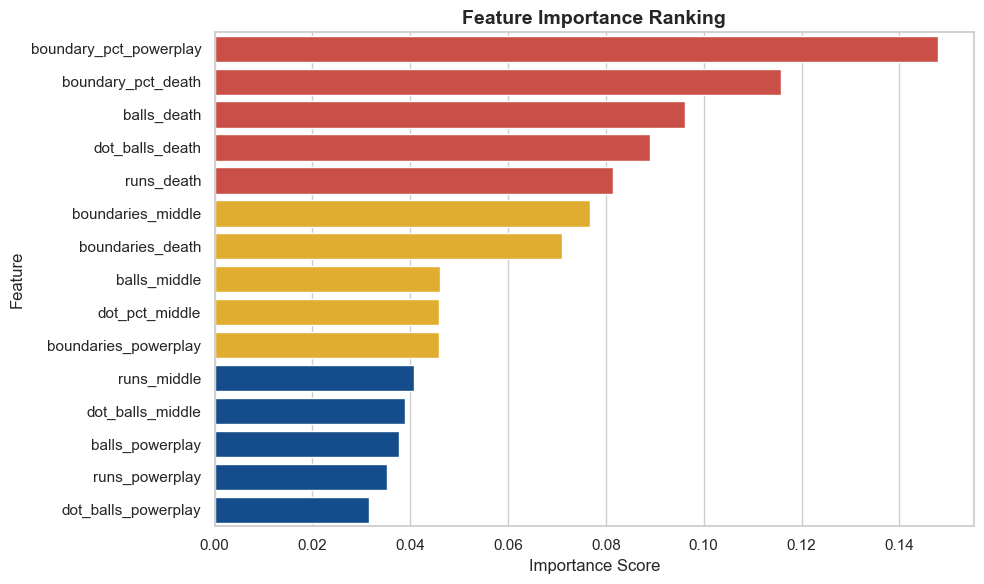

In [85]:
from matplotlib.colors import ListedColormap
import numpy as np

# Get feature importance
importances = rf.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Create IPL role-themed gradient palette
ipl_cmap = ListedColormap(["#E03C31", "#FDB913", "#004BA0"])  # RCB Red → CSK Yellow → MI Blue
custom_colors = sns.color_palette(ipl_cmap(np.linspace(0, 1, len(features_df))))

# Plot feature importance with custom palette
plt.figure(figsize=(10, 6))
sns.barplot(y='Feature', x='Importance', data=features_df, palette=custom_colors)
plt.title("Feature Importance Ranking", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

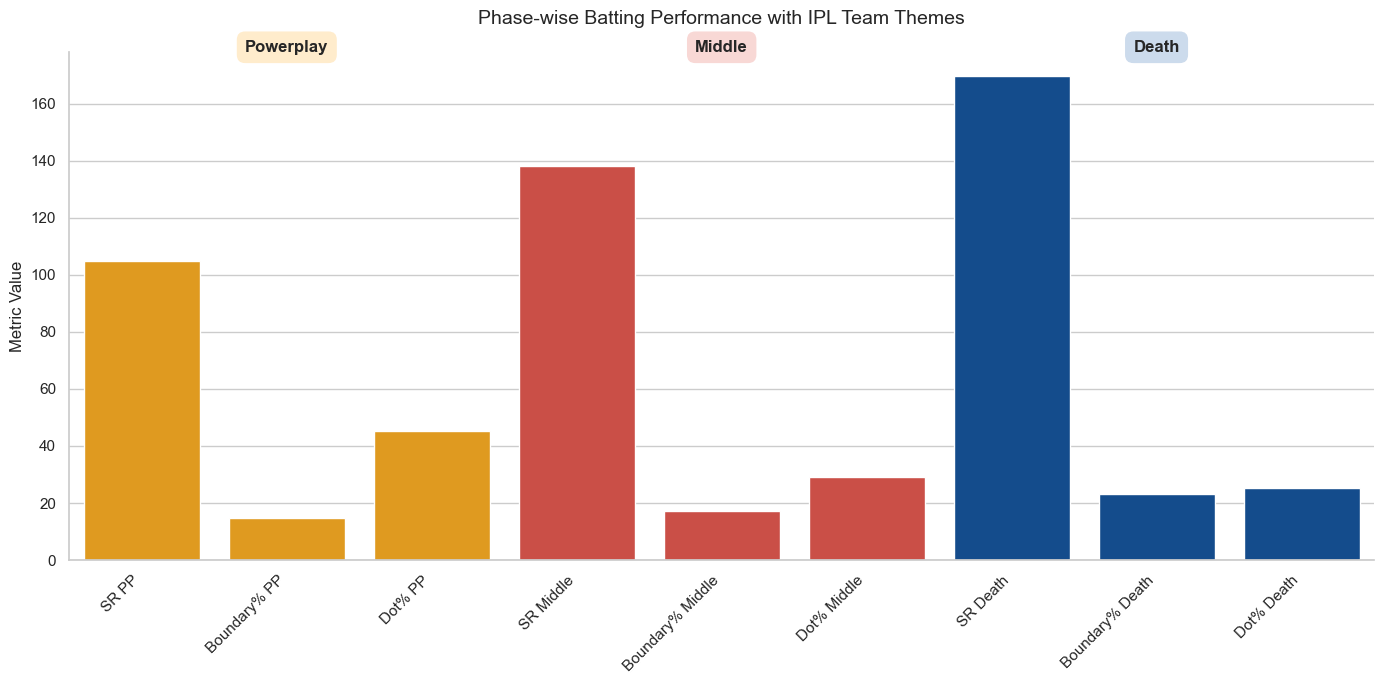

In [78]:
# Define IPL team colors (full palette)
ipl_palette = {
    "RCB": "#E03C31",       # Royal Challengers Bangalore (Red)
    "MI": "#004BA0",        # Mumbai Indians (Blue)
    "CSK": "#FDB913",       # Chennai Super Kings (Yellow)
    "KKR": "#2C2C54",       # Kolkata Knight Riders (Purple)
    "SRH": "#FFA300",       # Sunrisers Hyderabad (Orange)
    "RR": "#5D8A2B",        # Rajasthan Royals (Green)
    "DC": "#004C93",        # Delhi Capitals (Navy Blue)
    "PBKS": "#AA4545",      # Punjab Kings (Red-Maroon)
}

# Select only SRH, RCB, MI colors
team_colors = {
    "SRH": ipl_palette["SRH"],  # Orange for Powerplay
    "RCB": ipl_palette["RCB"],  # Red for Middle overs
    "MI": ipl_palette["MI"]     # Blue for Death overs
}

# Create color mapping for each phase (3 metrics per phase)
phase_colors = [
    team_colors["SRH"], team_colors["SRH"], team_colors["SRH"],  # Powerplay metrics
    team_colors["RCB"], team_colors["RCB"], team_colors["RCB"],  # Middle overs metrics
    team_colors["MI"], team_colors["MI"], team_colors["MI"]      # Death overs metrics
]

# Create the plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x='Metric', 
    y='Value', 
    data=phase_means, 
    palette=phase_colors
)

# Add phase/team labels
phases = ['Powerplay', 'Middle', 'Death']
for i, phase in enumerate(phases):
    ax.text(
        x=i*3 + 1,  # Center of each phase group
        y=phase_means['Value'].max() * 1.05,
        s=phase,
        ha='center',
        fontsize=12,
        fontweight='bold',
        bbox=dict(
            facecolor=list(team_colors.values())[i], 
            alpha=0.2, 
            edgecolor='none',
            boxstyle='round,pad=0.5'
        )
    )

# Customize plot
plt.title('Phase-wise Batting Performance with IPL Team Themes', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Metric Value', fontsize=12)
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

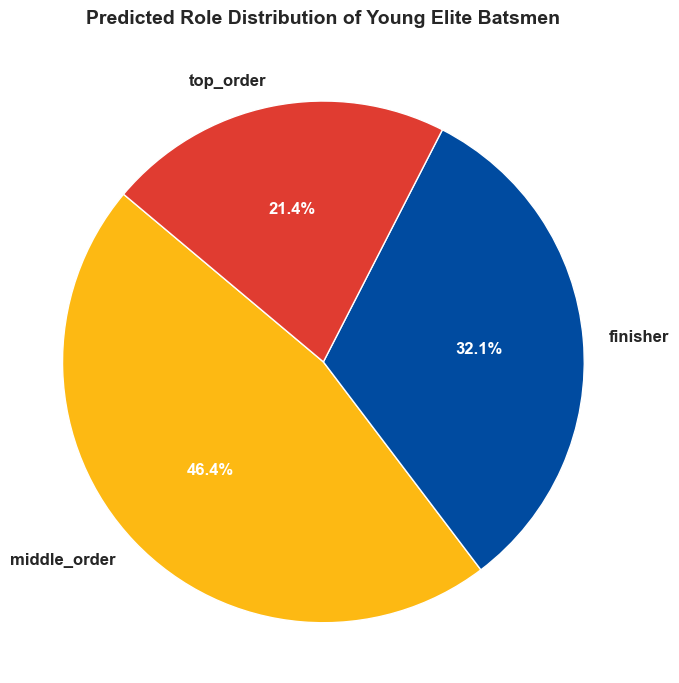

In [82]:
# Predict roles and assign
valid_roles_clean['predicted_role'] = rf.predict(X_scaled)

# Filter elite players
elite_roles = valid_roles_clean[valid_roles_clean['elite'] == 1]

# Count role predictions
role_counts = elite_roles['predicted_role'].value_counts()

# Custom colors for roles based on IPL teams
role_color_map = {
    'top_order': "#E03C31",     # RCB Red
    'middle_order': "#FDB913",  # CSK Yellow
    'finisher': "#004BA0"       # MI Blue
}
role_colors = [role_color_map[role] for role in role_counts.index]

# Plot standard pie chart
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    role_counts, 
    labels=role_counts.index, 
    autopct='%1.1f%%',
    startangle=140,
    colors=role_colors,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Style percentages
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Title and layout
plt.title('Predicted Role Distribution of Young Elite Batsmen', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

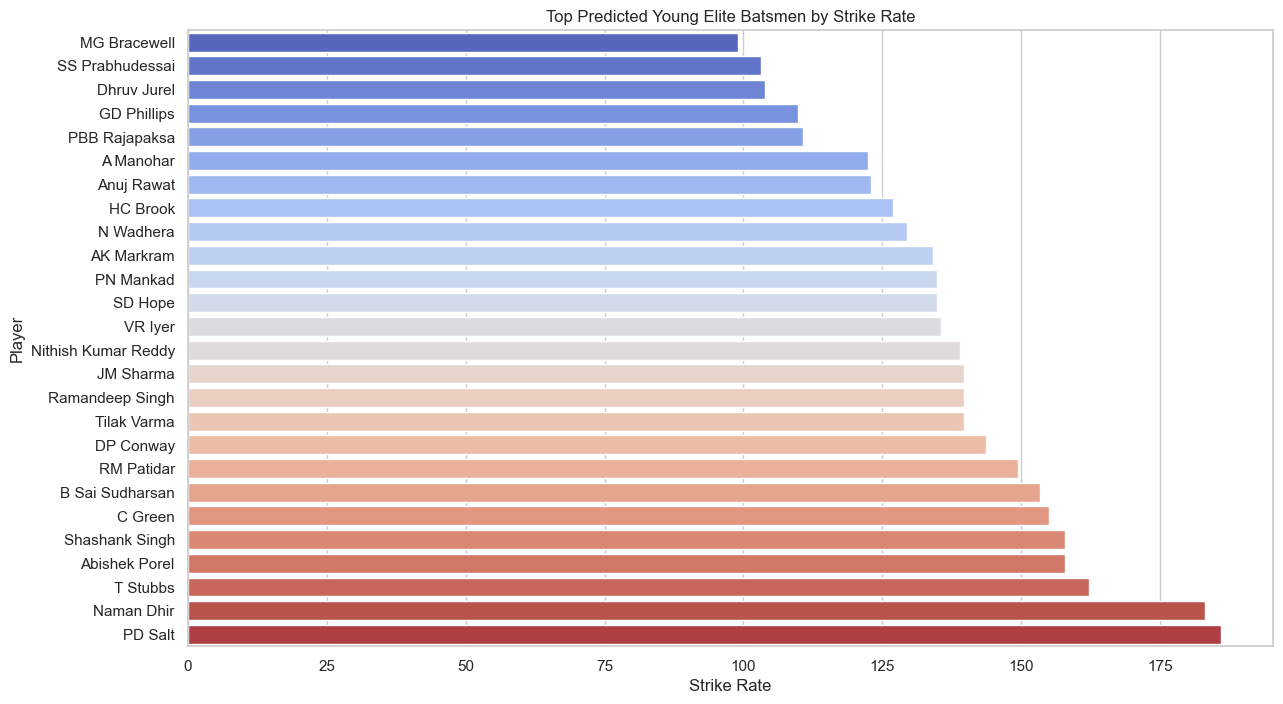

In [ ]:
plt.figure(figsize=(14,8))
top_elites = elite_roles.copy()
top_elites['strike_rate'] = top_elites[['sr_powerplay', 'sr_middle', 'sr_death']].mean(axis=1)
sns.barplot(x='strike_rate', y='batter', data=top_elites.sort_values('strike_rate'), palette='coolwarm')
plt.title("Top Predicted Young Elite Batsmen by Strike Rate")
plt.xlabel("Strike Rate")
plt.ylabel("Player")
plt.show()